In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import os
path = os.getcwd()
print(path)
PATH = path + "/pytorch_sample/data"

device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
print(f'{device} is available')
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context

c:\Users\bm990\Desktop\백업\Python_Code\DL
Files already downloaded and verified
Files already downloaded and verified


In [6]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataset = torchvision.datasets.CIFAR10(root=PATH, train=True, download=True, transform=transform)

trainset, valset = torch.utils.data.random_split(dataset, [30000, 20000])
testset = torchvision.datasets.CIFAR10(root=PATH, train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
valloader = DataLoader(valset, batch_size=32, shuffle=False)
testloader = DataLoader(testset, batch_size=32, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.stride = stride
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.conv_block = nn.Sequential(
            nn.Conv2d(self.in_channels, self.out_channels, kernel_size=3, stride=stride,padding=1, bias=False),
            nn.BatchNorm2d(self.out_channels),
            nn.ReLU(),
            
            nn.Conv2d(self.out_channels, self.out_channels, kernel_size=3, stride=1,padding=1, bias=False),
            nn.BatchNorm2d(self.out_channels))
            
        if self.stride !=1 or self.in_channels != self.out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, self.out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.out_channels))
    
    def forward(self, x):
        out = self.conv_block(x)
        if self.stride != 1 or self.in_channels != self.out_channels:
            x = self.downsample(x)
        
        # print(out.shape)
        # print(x.shape)
        out = F.relu(x+out)
        return out

In [4]:
class ResNet(nn.Module):
    def __init__(self, num_blocks, num_class = 10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.base = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer1 = self._make_layer(64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(512, num_blocks[3], stride=2)
        self.gap = nn.AvgPool2d(4)
        self.fc = nn.Linear(512, num_class)
        
    def _make_layer(self, out_channels, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            block = ResidualBlock(self.in_channels, out_channels, stride)
            layers.append(block)
            self.in_channels = out_channels
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.base(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.gap(out)
        out = out.view(out.size(0), -1)
        return out
    
def modeltype(model):
    if model == 'resnet18':
        return ResNet([2, 2, 2, 2])
    elif model == 'resnet34':
        return ResNet([3, 4, 6, 3])   

In [7]:
def validaion_loss(dataloader):
    n = len(dataloader)
    running_loss = 0.0
    with torch.no_grad():
        resnet.eval()
        for data in dataloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = resnet(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    resnet.train()
    return running_loss / n

In [24]:
resnet = modeltype('resnet18').to(device)
print(resnet)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=1e-3)

loss_ = []
train_loss_list = []
val_loss_list = []
early_stopping_loss = 1
n = len(trainloader)

for epoch in range(51):
    running_loss = 0.0
    for data in trainloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = resnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    
    train_loss = running_loss / n
    train_loss_list.append(train_loss)
    val_loss = validaion_loss(valloader)
    val_loss_list.append(val_loss)
        
    # loss_.append(running_loss / n)
    print('[%d] train loss : %.3f, validation loss: %.3f'%(epoch + 1, train_loss, val_loss))
    if val_loss < early_stopping_loss:
        torch.save(resnet.state_dict(), path + '/Pytorch_sample/models/val_test.pt')
        early_stopping_train_loss = train_loss
        early_stopping_val_loss = val_loss
        early_stopping_epoch = epoch

print('Final pretrained model >> [%d] train loss : %.3f, validataion loss : %.3f' %(early_stopping_epoch + 1, early_stopping_train_loss, early_stopping_val_loss))
PATH2 = path + './models/cifar_resnet.pth'


ResNet(
  (base): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv_block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ResidualBlock(
      (conv_block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kerne

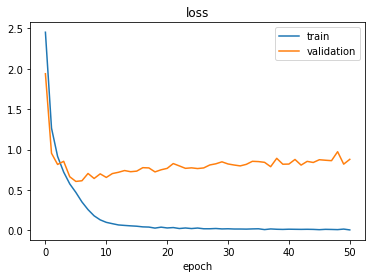

In [25]:
plt.plot(train_loss_list)
plt.plot(val_loss_list)
plt.legend(['train', 'validation'])
plt.title("loss")
plt.xlabel('epoch')
plt.show()